<img src="https://pbs.twimg.com/profile_images/969600936321736704/WrwKmb8y_400x400.jpg" width="200" height="200" />

# Fitting Growth Response
Rather than model the sensitivities, we can model the growth curve directly. For simplicity, lets assume the the growth factor curve has a gaussian shape, with 3 parameters, a $\mu$, $\sigma$ and $A$ (Normalisation).
$$ A\exp{(-0.5((T-\mu)/\sigma)^2)}$$
Lets fit this on the US states growing Maize.

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import pystan

%matplotlib inline

In [2]:
# Read in climate temperatures
clim_precip_maize=pd.read_table('./Crop_data_files/clim_file/temp_climatology_Maize.csv')
clim_precip_maize.rename(columns = {'Unnamed: 0':'Crop_season_location'}, inplace = True)

### Define states to fit over

In [3]:
states=['Indiana','Illinois']

In [4]:
#Read in and add back mean temperature to get real temperature values
temp_states=[]
for i,s in enumerate(states):
    maize_temp=pd.read_table('./Crop_data_files/maize_met_anoms/Maize_Spring_USA_'+s+'_temp_anom_real.csv')
    maize_temp.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
    tmp=maize_temp.iloc[:,1:].add(clim_precip_maize[clim_precip_maize['Crop_season_location']== 'Maize_Spring_USA_'+states[0]].iloc[0,1:,])
    temp_states.append(tmp)
temp_states=pd.concat(temp_states,keys=states)

In [5]:
temp_states

Jan         Feb       Mar      Apr      May      Jun  \
Indiana  0     -1.9534    -3.97301   2.59058  10.0881  17.3264  20.9624   
         1    -4.00883    0.874847   4.86918  13.9457  15.2778  22.6881   
         2    -6.41284    -2.59879    4.7838  8.75127  19.9566  19.5645   
         3   -0.465296     1.96229    6.1551  9.13795  15.1196  22.1406   
         4    -5.10546     3.22889  0.673888  10.3269  15.3663   23.748   
         5    -5.70493    -2.89812   7.23863  14.3429  18.4319  20.7701   
         6   -0.912048   -0.499908   6.81455  13.4268  17.8881  22.5552   
         7    -1.76537     1.84541   7.20209  11.7326  20.2266  23.5955   
         8    -3.01212    -1.95634    5.6462  11.3608  18.0358  23.2077   
         9     2.67857    -2.49459   6.04169  10.5955  15.5242  21.7484   
         10    3.44255     3.09323   7.68794  11.0972  15.7078  22.1507   
         11   -2.28052     2.21587   7.22717  13.4812  20.8521  23.6615   
         12   -0.16997     3.40981   5.74444  11.0505  16.1849  19.7391   
         13 -0.0173301    -2.03527   3.39191  10.4553  17.5315  21.5171   
         14   -5.85973    -1.65559   4.84746  12.7552  15.6909  23.4092   
         15   -1.37723   -0.592061   6.55102  11.1221  16.6471  22.5709   
         16   -2.70339   -0.100481   2.02085  10.0078  16.7241  22.2153   
         17   -3.63169     1.65543    5.8699  8.89772  13.6574  20.9806   
         18    2.05681      4.4293   5.56694  11.4184  19.4995  21.8538   
         19    -2.0289     2.81877   2.99723  12.1992  17.8924  22.6487   
         20   -2.26375     3.58884   8.04499  10.7229  18.4269   21.601   
         21   -2.02941     1.16934   3.36088   14.056   17.822  21.0009   
         22    2.27671     2.44643   4.32397  12.4996  15.0693  22.9426   
         23   -5.02928    -2.90573   6.12223  11.9321  15.7047  19.9331   
         24   -3.58426   0.0155546   7.17004  12.4253  19.1386  21.2121   
         25   -1.42508     1.99761   3.30135  12.6427  15.3971  23.8479   
         26    4.19659    0.528402   5.20404  13.5371  16.4012  21.2803   
         27   0.254286    -5.87735   8.93536  10.4911   19.447  22.9623   
         28   -1.34529    -1.50774   4.07293  12.0195  15.6034  22.6876   
         29   -5.16117    0.970609   7.58417  11.6994  17.0706  22.4303   
...                ...         ...       ...      ...      ...      ...   
Illinois 5    -6.44611    -3.25317   7.26484  14.0275  18.3249  20.6852   
         6   -0.713717    -1.53456   7.01301  13.7606  17.9516  22.8154   
         7     -1.6276     3.22802   7.37963  12.3176  20.2409   23.777   
         8     -3.6431    -2.59349    5.5205  11.6661  18.3177  23.4527   
         9     2.96652      -4.575   5.04462  10.8039  15.6353  21.3316   
         10    3.84661     2.78719   7.54843   11.077  15.3147  22.4571   
         11   -3.71208     2.42629   7.24827  13.5932  20.4384  23.7141   
         12   0.770789     3.79435   6.46778  11.0525  16.5254  20.4991   
         13   -1.12818    -1.87601    3.0795  9.96675  17.5049  21.5514   
         14   -5.77954    -2.04553   5.48024  12.4232  16.2034  23.3788   
         15   -2.34812   -0.239081    6.3789   10.555  15.9823  22.5788   
         16   -3.27414  -0.0182295   1.88724  9.79223  16.4948  21.8911   
         17   -4.44076     1.16078   6.02061  8.82376  14.2121  21.2678   
         18   0.904613     4.89271    4.8791  11.4484  19.6494  21.7917   
         19   -2.52907     3.80812   3.70857  12.4094  17.7243  22.0654   
         20   -1.36748     4.10966   8.03278  11.0351  18.5606  21.0347   
         21    -2.1482   -0.343919   3.02297  14.6286   17.865  21.0539   
         22    2.41173     2.63582   3.69145  12.2246  15.1756  23.0904   
         23   -3.69095    -2.33153   5.68045  11.8756  15.9239   20.027   
         24     -2.992    0.240449   7.49929  12.4854  18.7631  20.9786   
         25   -1.17482      2.9631   4.34413  13.0722  16.1282  23.9788   
         26    4.56373     0.45989   5.60797

In [6]:
# Compile model
sm=pystan.StanModel(file='BMSM-GaussGR.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1e86ee7c041279b4486de8d350a23560 NOW.


In [7]:
# Read in Yields
yields=pd.read_table('./Crop_data_files/Maize_median_yield_anoms.csv')

In [8]:
yields

,Unnamed: 0,Region,1960,1961,1962,1963,1964,1965,1966,1967,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,0,Maize_Spring_USA_Nebraska,-0.06276,-0.15690,0.40794,0.00000,-0.40794,0.00000,0.37656,0.00000,...,0.00000,-0.50208,0.00000,0.00000,1.00416,0.18828,-0.37656,-1.506240,0.28242,0.62760
1,1,Maize_Spring_USA_Iowa,-0.75312,-0.04707,0.00000,0.15690,-0.15690,0.00000,0.03138,-0.03138,...,0.12552,-0.31380,0.00000,0.00000,0.62760,-0.37656,0.43932,-1.757280,-0.25104,0.87864
2,2,Maize_Spring_USA_Illinois,-0.69036,-0.18828,0.31380,0.12552,-0.31380,0.43932,-0.50208,0.62760,...,-1.31796,-0.75312,0.06276,0.31380,0.00000,0.00000,0.00000,-3.263520,0.65898,1.38072
3,3,Maize_Spring_USA_Indiana,-0.37656,-0.25104,0.50208,0.31380,-0.62760,0.50208,-0.37656,-0.12552,...,0.00000,0.00000,-0.18828,0.18828,0.87864,0.00000,-0.69036,-3.640080,0.97278,0.69036
4,4,Maize_Spring_USA_Minnesota,-0.34518,0.15690,0.00000,0.50208,-0.18828,-0.50208,0.25104,-0.25104,...,0.94140,0.00000,-1.00416,0.00000,0.75312,0.75312,-0.62760,0.376560,0.09414,-0.18828
5,5,Maize_Spring_USA_Ohio,-0.37656,-0.06276,0.12552,0.25104,-0.69036,-0.25104,0.31380,-0.31380,...,-0.81588,0.56484,0.00000,-1.75728,1.12968,0.43932,-0.43932,-2.510400,0.65898,0.12552
6,6,Maize_Spring_China_Jilin,-0.23500,0.11935,-0.03450,-0.04300,0.05020,-0.05020,0.00000,0.13240,...,0.18101,0.58294,-0.18101,0.54988,-0.45689,-0.54988,0.00000,0.194480,0.08097,NaN
7,7,Maize_Spring_China_Liaoning,-0.49600,-0.05390,0.00000,0.00000,0.00000,0.00000,0.00000,0.17770,...,0.01228,-0.19889,-0.26599,0.46488,-0.93963,-0.81114,0.00000,0.039145,0.51029,NaN
8,8,Maize_Spring_China_Heilongjiang,1.41700,-0.28565,0.00000,0.07270,-0.09070,-0.00440,0.00000,0.35160,...,0.38670,0.00000,-0.98415,0.28129,-0.28129,0.00000,0.26910,-0.134550,0.07151,NaN
9,9,Maize_Summer_China_Hebei,-0.10190,0.05095,0.01090,-0.17080,0.00000,0.00000,0.15120,0.07440,...,0.00000,0.00000,0.00079,0.10930,-0.04865,-0.06144,0.00000,0.004350,0.07125,NaN


In [17]:
n_years=np.array(yields[yields['Region']=='Maize_Spring_USA_Indiana'].iloc[0,22:]).size
data={
    'n_regions':2,
    'n_years':n_years,
    'd_temp':np.array(temp_states.iloc[:,3:9]).reshape(len(states),np.int(np.array(temp_states.iloc[:,3:9]).shape[0]/len(states)),6).astype(float),
    'd_yields':np.array(yields[yields["Region"].isin(['Maize_Spring_USA_'+s for s in states])].iloc[:,22:]).astype(float)+6,
    'n_gf':40,
    'temp':np.arange(0,40,1)

}

In [18]:
fit=sm.sampling(data=data,chains=4,iter=1000,verbose=True,seed=1308)

In [19]:
fit

Inference for Stan model: anon_model_1e86ee7c041279b4486de8d350a23560.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       18.47    0.03   0.88  16.55  17.95  18.55  19.06  19.97    682   1.01
sigma     4.41    0.02   0.55   3.53   4.01   4.35   4.75   5.69    626    1.0
norm      1.51  4.1e-3   0.11   1.32   1.44    1.5   1.57   1.73    684    1.0
fdy[0]  2.0e-3  2.9e-4 7.7e-3 4.8e-7 2.5e-5 1.6e-4 9.5e-4   0.02    693    1.0
fdy[1]  3.4e-3  4.4e-4   0.01 2.2e-6 7.8e-5 4.2e-4 2.1e-3   0.03    670    1.0
fdy[2]  5.9e-3  6.6e-4   0.02 8.7e-6 2.2e-4 1.0e-3 4.5e-3   0.04    647    1.0
fdy[3] 10.0e-3  9.7e-4   0.02 3.4e-5 6.1e-4 2.4e-3 8.9e-3   0.07    626    1.0
fdy[4]    0.02  1.4e-3   0.03 1.2e-4 1.6e-3 5.4e-3   0.02   0.11    607    1.0
fdy[5]    0.03  2.0e-3   0.05 4.0e-4 3.9e-3   0.01   0.03   0.16    592    1.0
fdy[6]    0.05  2.7e-3 

In [20]:
# carry out some diagnostic checks on fit
from xidplus.stan_fit import stan_utility
stan_utility.check_div(fit)
stan_utility.check_energy(fit)
stan_utility.check_treedepth(fit)

0.0 of 2000 iterations ended with a divergence (0.0%)
0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)


In [21]:
samples=fit.extract()

Text(0.5,1,'Growth Curve')

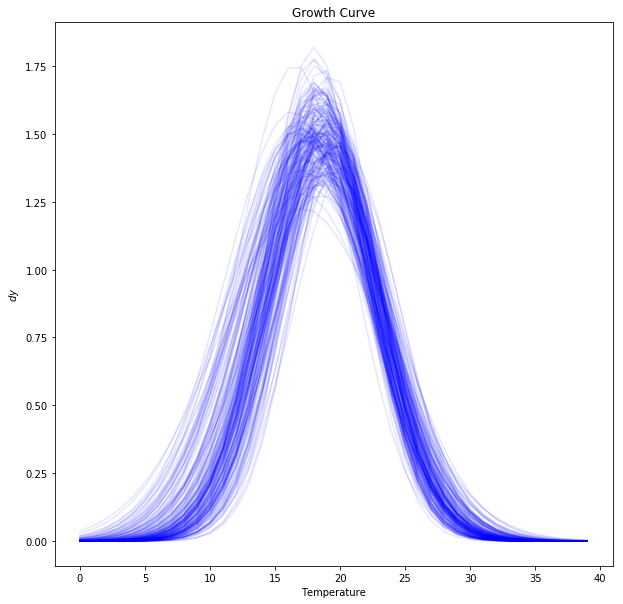

In [29]:
plt.figure(figsize=(10,10))
for i in range(0,2000,10):
    plt.plot(fit.data['temp'],samples['fdy'][i,:],alpha=0.1, c='b')
plt.xlabel('Temperature')
plt.ylabel(r'$dy$')
plt.title('Growth Curve')

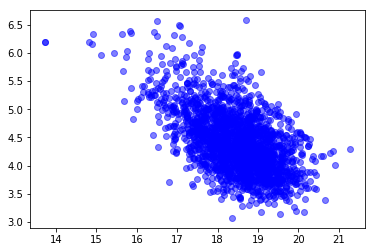

In [23]:
plt.plot(samples['mu'],samples['sigma'], 'bo', alpha=0.5)

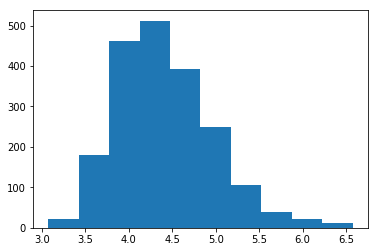

In [25]:
plt.hist(samples['sigma']);